# Category Recomendation Random Forest
---

In [24]:
# imports
import json
import time
import random
import pickle
import matplotlib.pyplot as plt
from sys import getsizeof

import pandas as pd
import joblib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import top_k_accuracy_score, label_ranking_average_precision_score

In [25]:
data_path : str = "./dataset/"
models_path : str = "../web/models/local/"
cities =  ["Burgos", "León", "Palencia", "Salamanca", "Valladolid"]


In [26]:
def construct_dataset(data_path: str) -> dict:

    # Abrimos el fichero de datos y lo convertimos a un dataframe
    with open(data_path, "r") as file:
        data = json.load(file)
    df = pd.json_normalize(data)

    # Contamos las apariciones de cada categoría
    category_count = df['Categoria'].value_counts()

    # Obtenemos dataframes para aquellas categorías con una única aparición
    single_categories = df[df['Categoria'].isin(category_count[category_count == 1].index)]
    single_categories_attr = single_categories.drop('Categoria', axis=1)
    single_categories_y = single_categories['Categoria']

    # Eliminamos las categorías con una única aparición del conjunto de datos
    df = df.drop(single_categories.index)

    # Separamos en dataframes de atributos y etiquetas
    df_attr = df.drop('Categoria', axis=1)
    df_y = df['Categoria']

    dataset = {
        "single_categories_X" : single_categories_attr,
        "single_categories_Y" : single_categories_y,
        "X" : df_attr,
        "Y" : df_y
    }

    return dataset  

In [27]:
def mean_reciprocal_rank(real_categories, category_probs, categories) -> float:
    mrr: float = 0
    sample_size = len(category_probs)

    for real, probs in zip(real_categories, category_probs):
        ranking: list = [[category, prob]
                         for category, prob in zip(categories, probs)]
        ranking.sort(key=lambda x: x[1], reverse=True)

        for index, prob in enumerate(ranking, start=1):
            if prob[0] == real:
                mrr += 1/index
                break

    return mrr/sample_size


In [28]:
def cross_validate_random_forest(dataset, k=5, **kwargs):

    # Creamos el objeto para KFold para hacer validación cruzada
    kf = KFold(n_splits=k, shuffle=True, random_state=random.randint(0, 100))

    # Dataframes de atributos y etiquetas
    X = dataset["X"]
    Y = dataset["Y"]

    # Dataframes de categorías con una única aparición
    single_categories_x = dataset["single_categories_X"]
    single_categories_y = dataset["single_categories_Y"]

    folds_mrr = []

    if "city" in kwargs:
        print(f"[{kwargs['city']}]")

    for n_fold, (train, test) in enumerate(kf.split(X), start=1):
        print(f">>> Fold: {n_fold}")
        classifier = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
        fold_time = time.time()

        # Añadimos al conjunto de datos de entrenamiento las categorías con una sola aparición
        df_train_x = pd.concat([X.iloc[train], single_categories_x])
        df_train_y = pd.concat([Y.iloc[train], single_categories_y])

        # Definimos conjunto de test
        df_test_x = X.iloc[test]
        df_test_y = Y.iloc[test]

        # Entrenamos el modelo
        classifier.fit(df_train_x, df_train_y)

        # Predicciones
        preds = classifier.predict_proba(df_test_x)

        # Calculamos el MRR
        mrr = mean_reciprocal_rank(df_test_y, preds, classifier.classes_)
        folds_mrr.append(mrr)
        print(f"> MRR: {mrr}")
        print(f"> Tiempo fold {n_fold}: {time.time() - fold_time :.1f} s")

    return folds_mrr


In [29]:
def train_model(city):

    with open(f"{data_path}Q_{city}.json", "r") as file:
        data = json.load(file)
    df = pd.json_normalize(data)

    # Dataframes de atributos y etiquetas
    df_attr = df.drop('Categoria', axis=1)
    df_y = df['Categoria']

    classifier = RandomForestClassifier(n_estimators=1000, n_jobs=-1)

    classifier.fit(df_attr, df_y)
    print(f"----------- Tamaño: {getsizeof(classifier)}")
    with open(f"{models_path}/{city}.pkl", "wb") as model_file:
        pickle.dump(classifier, model_file)
    

In [30]:
cities_mrr = dict()

for city in cities:
    dataset = construct_dataset(f"{data_path}Q_{city}.json")
    cities_mrr[city] = cross_validate_random_forest(dataset, city=city, k=5)
    train_model(city)
    

print(cities_mrr)


[Burgos]
>>> Fold: 1
> MRR: 0.27352051799098714
> Tiempo fold 1: 94.8 s
>>> Fold: 2
> MRR: 0.25659167277967126
> Tiempo fold 2: 91.5 s
>>> Fold: 3
> MRR: 0.26532162162681094
> Tiempo fold 3: 90.7 s
>>> Fold: 4
> MRR: 0.28104243542004625
> Tiempo fold 4: 94.7 s
>>> Fold: 5
> MRR: 0.28681971768157954
> Tiempo fold 5: 91.9 s
----------- Tamaño: 48
[León]
>>> Fold: 1
> MRR: 0.351574430341518
> Tiempo fold 1: 4.9 s
>>> Fold: 2
> MRR: 0.3815418264233261
> Tiempo fold 2: 5.0 s
>>> Fold: 3
> MRR: 0.39338950427049807
> Tiempo fold 3: 6.1 s
>>> Fold: 4
> MRR: 0.40898993261598776
> Tiempo fold 4: 5.2 s
>>> Fold: 5
> MRR: 0.34533932277720675
> Tiempo fold 5: 5.0 s
----------- Tamaño: 48
[Palencia]
>>> Fold: 1
> MRR: 0.36477768008686845
> Tiempo fold 1: 9.2 s
>>> Fold: 2
> MRR: 0.2628634768293544
> Tiempo fold 2: 8.7 s
>>> Fold: 3
> MRR: 0.2623897277781798
> Tiempo fold 3: 8.8 s
>>> Fold: 4
> MRR: 0.29218509023284367
> Tiempo fold 4: 9.1 s
>>> Fold: 5
> MRR: 0.3513905197681798
> Tiempo fold 5: 9.1 

In [31]:
with open("./MRR.json", "r", encoding="utf-8") as read_json,  open("./CompleteMRR.json", "w", encoding="utf-8") as write_json:
    complete_mrr = json.load(read_json)

    for city in cities:
        complete_mrr[city]["Qrandom_forest"] = np.average(cities_mrr[city])
        plt.figure(figsize=(16,9), dpi=300)
        plt.bar(complete_mrr[city].keys(), complete_mrr[city].values(), color='green')
        plt.title(city)
        plt.xlabel('Índices de calidad')
        plt.ylabel('MRR')
        plt.savefig(f"./plots/{city}.png")
        plt.close('all')

    json.dump(complete_mrr,write_json, indent=4, ensure_ascii=False)



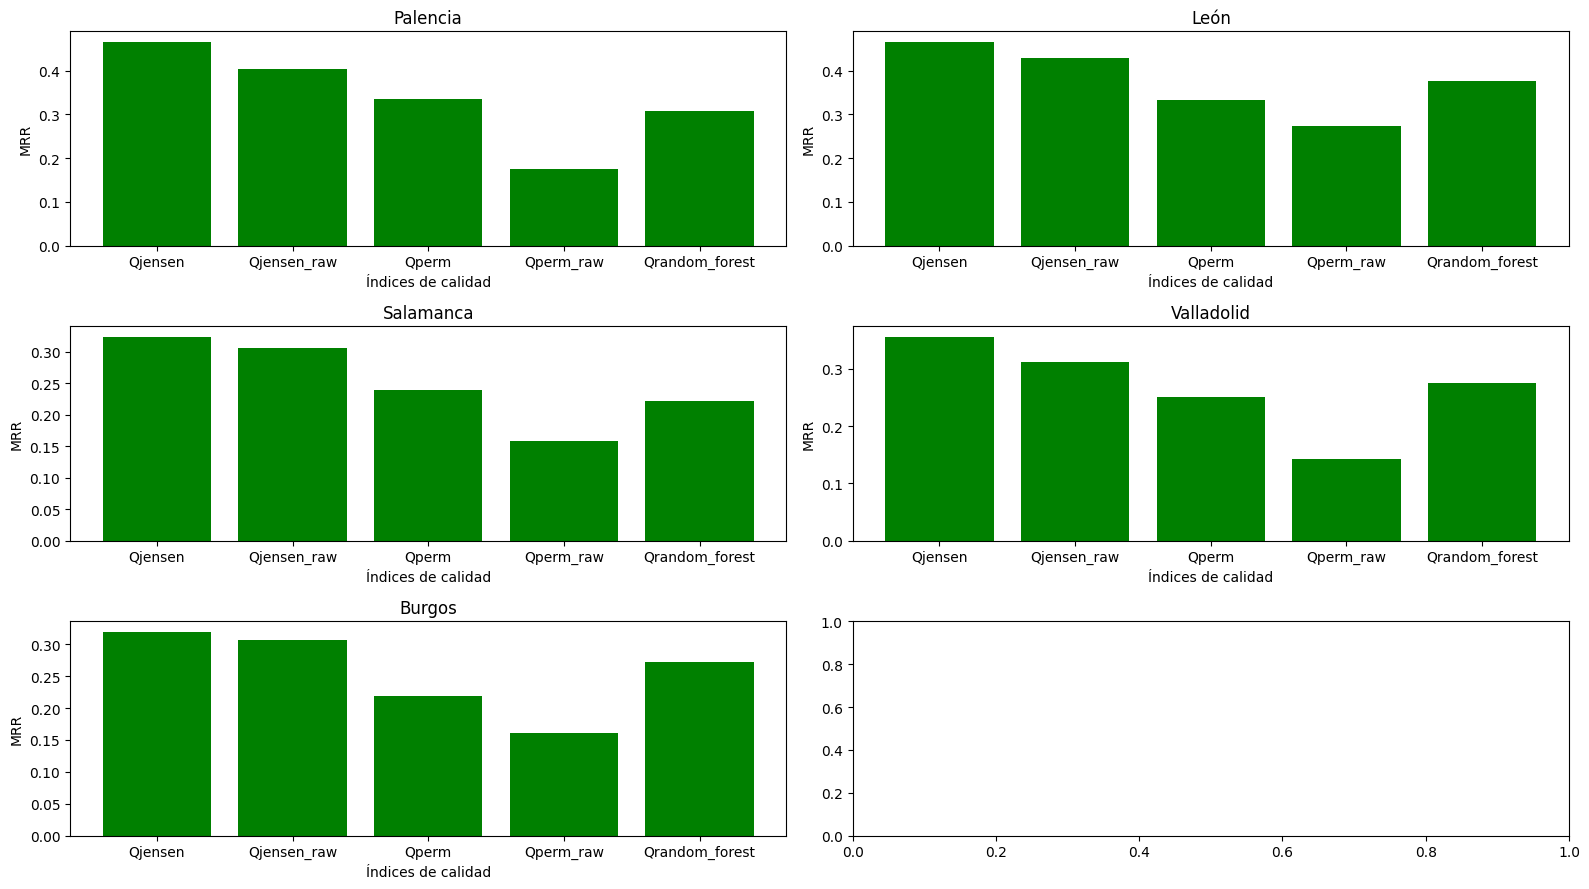

In [32]:
fig, axs = plt.subplots(3,2, figsize=(16,9), layout='tight')

for ax, city_mrr in zip(axs.flat, complete_mrr.keys()):
    ax.bar(complete_mrr[city_mrr].keys(),complete_mrr[city_mrr].values(), color='green')
    ax.set_title(city_mrr)
    ax.set_xlabel('Índices de calidad')
    ax.set_ylabel('MRR')
plt.show()